In [1]:
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v3_small
import matplotlib.pyplot as plt

from tensordict import TensorDict
from tensordict.nn import TensorDictModule, TensorDictSequential
from tensordict.nn.distributions import NormalParamExtractor
from torchrl.envs.transforms import CatTensors
from torchrl.data import TensorSpec, CompositeSpec, UnboundedContinuousTensorSpec

from torchrl.data.replay_buffers.storages import LazyMemmapStorage
from torchrl.data.replay_buffers import TensorDictReplayBuffer

import os
from tqdm import tqdm

buffer = TensorDictReplayBuffer(
    batch_size=128,
    storage=LazyMemmapStorage(800*4*10, scratch_dir="tmp"),
)
traj_dir = "./trajectories"
for traj_file in tqdm(os.listdir(traj_dir)[:10], desc="loading data"):
    td: TensorDict = torch.load(os.path.join(traj_dir, traj_file))
    buffer.extend(td.reshape(-1))
td

/home/botian/miniconda3/envs/sim/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
loading data: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


TensorDict(
    fields={
        control_target: Tensor(shape=torch.Size([4, 800, 7]), device=cpu, dtype=torch.float32, is_shared=False),
        drone.action: Tensor(shape=torch.Size([4, 800, 1, 6]), device=cpu, dtype=torch.float32, is_shared=False),
        drone.obs: TensorDict(
            fields={
                distance_to_camera: Tensor(shape=torch.Size([4, 800, 1, 1, 240, 320]), device=cpu, dtype=torch.float32, is_shared=False),
                state: Tensor(shape=torch.Size([4, 800, 1, 25]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([4, 800, 1]),
            device=cpu,
            is_shared=False)},
    batch_size=torch.Size([4, 800]),
    device=cpu,
    is_shared=False)

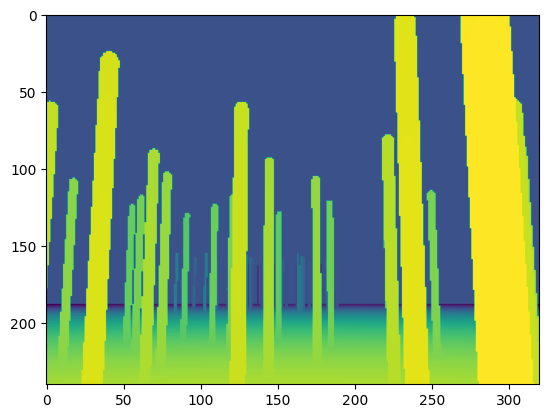

In [4]:
plt.imshow(1-buffer.sample()[("drone.obs", "distance_to_camera")][0, 0].permute(1, 2, 0))

In [11]:
from omni_drones.learning.utils.distributions import IndependentNormal
from omni_drones.learning.utils.network import MLP

class NormalParam(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.linear = nn.LazyLinear(output_dim)
        self.log_std = nn.Parameter(torch.zeros(output_dim))
    
    def forward(self, input):
        loc = self.linear(input)
        scale = torch.broadcast_to(torch.exp(self.log_std), loc.shape)
        return loc, scale
    
class Actor(nn.Module):

    def forward(self, loc, scale):
        dist = IndependentNormal(loc, scale)
        action = dist.sample()
        logp = dist.log_prob(action).unsqueeze(-1)
        return action, logp

class ActorEval(nn.Module):

    def forward(self, action, loc, scale):
        dist = IndependentNormal(loc, scale)
        logp = dist.log_prob(action).unsqueeze(-1)
        entropy = dist.entropy()
        return logp, entropy

def make_model(
    input_spec: CompositeSpec,
    action_spec: TensorSpec,
    device: torch.device="cpu"
):
    visual_encoder = nn.Sequential(
        nn.Conv2d(1, 3, 1),
        mobilenet_v3_small(num_classes=128)
    )
    state_input_shape = input_spec["state"].shape
    state_encoder = MLP([state_input_shape[-1], 128], normalization=nn.LayerNorm)
    encoder = TensorDictSequential(
        TensorDictModule(visual_encoder, [("drone.obs", "distance_to_camera")], ["visual_feature"]),
        TensorDictModule(state_encoder, [("drone.obs", "state")], ["state_feature"]),
        CatTensors(["state_feature", "visual_feature"], "feature"),
        TensorDictModule(MLP([128 + 128, 128]), ["feature"], ["feature"]),
        TensorDictModule(NormalParam(action_spec.shape[-1]), ["feature"], ["loc", "scale"]),
    ).to(device)
    actor = TensorDictSequential(
        encoder,
        TensorDictModule(Actor(), ["loc", "scale"], ["action", "logp"])
    )
    actor_eval = TensorDictSequential(
        encoder,
        TensorDictModule(ActorEval(), ["drone.action", "loc", "scale"], ["logp", "entropy"])
    )
    return actor, actor_eval 

device = "cuda:0"
actor, actor_eval = make_model(
    input_spec=CompositeSpec({
        "state": UnboundedContinuousTensorSpec(25),
    }),
    action_spec=UnboundedContinuousTensorSpec(6),
    device=device
)
opt = torch.optim.Adam(actor.parameters(), lr=0.005)

/home/botian/isaac_ws/_isaac_sim/extscache/omni.pip.torch-1_13_0-0.1.4+104.1.lx64/torch-1-13-0/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [12]:
for epoch in range(4):
    t = tqdm(range(512))
    actor.train()
    for _ in t:
        batch = buffer.sample().to(device)
        batch["drone.obs"] = batch["drone.obs"].squeeze(1)
        batch["drone.action"] = batch["drone.action"].squeeze(1)
        actor_output = actor_eval(batch)
        loss = - torch.mean(actor_output["logp"])
        opt.zero_grad()
        loss.backward()
        opt.step()
        t.set_postfix({"loss": loss.item()})
    actor.eval()

100%|██████████| 512/512 [00:26<00:00, 19.52it/s, loss=-3.63]
